In [6]:
import pandas as pd

### hugging face
- dataset, sentence-bert load
  - ingredient , defination


In [1]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("yavuzyilmaz/cosmetic-ingredients")

README.md: 0.00B [00:00, ?B/s]

ingredients.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1020 [00:00<?, ? examples/s]

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['ingredient', 'description'],
        num_rows: 1020
    })
})

In [7]:
df = pd.DataFrame(ds['train'])
df = df.dropna(subset=['description'])
df.reset_index(drop=True, inplace=True)

print(len(df))
df.head()

1020


,ingredient,description
0,Glycerin,Glycerin doesn’t sound very glamorous but it i...
1,Butylene Glycol,"Butylene glycol, or let’s just call it BG, is ..."
2,Squalene,Squalene is an oily liquid that originally com...
3,Ceteareth-20,A common functional ingredient that helps to k...
4,Glyceryl Stearate,"A super common, waxy, white, solid stuff that ..."


In [5]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 전체 description 임베딩
embeddings = model.encode(df['description'].tolist(), convert_to_tensor=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 효능 기반 원료 추천

In [41]:
def recommend_by_text(query, top_k=5):
    q_embed = model.encode(query, convert_to_tensor=True)
    scores = util.cos_sim(q_embed, embeddings)[0]
    top = torch.topk(scores, k=top_k)

    print(f"Query: {query}\n")

    for score, idx in zip(top.values, top.indices):
        idx = int(idx)   # ★★★ 핵심 수정
        print(f"{df.iloc[idx]['ingredient']} | score={float(score):.4f}")
        print(" -", df.iloc[idx]['description'])
        print()

recommend_by_text("moisturizing")

Query: moisturizing

Saccharide Isomerate | score=0.6065
 - A 100% natural and plant-derived moisturizer that mimics the natural carbohydrate fraction found in the upper layer of the skin. Its special magic power is to bind to the skin stronger and longer than other moisturizer ingredients do so it can keep the skin hydrated longer than usual .

Tea-Lactate | score=0.6054
 - The salt form of lactic acid. It works as a moisturizer in skin care products.

Pentaerythrityl Tetraethylhexanoate | score=0.5702
 - A high-molecular-weight emollient ester that makes your skin nice and smooth. It leaves a non-oily, light, "wet" feel on the skin.

Dicaprylyl Ether | score=0.5673
 - A clear, colorless and odorless oily liquid that works as a fast-spreading emollient with a dry skin feel .

Dipropylene Glycol | score=0.5620
 - A clear, colorless liquid that works as a solvent and viscosity decreasing ingredient. It also has great skin-moisturizing abilities.



### 성분 설명 기반 clustering

In [42]:
from sklearn.cluster import KMeans

k = 10
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(embeddings.cpu().numpy())

df['cluster'] = labels
df.head()

,ingredient,description,cluster
0,Glycerin,Glycerin doesn’t sound very glamorous but it i...,0
1,Butylene Glycol,"Butylene glycol, or let’s just call it BG, is ...",2
2,Squalene,Squalene is an oily liquid that originally com...,7
3,Ceteareth-20,A common functional ingredient that helps to k...,1
4,Glyceryl Stearate,"A super common, waxy, white, solid stuff that ...",2


In [23]:
for c in range(k):
    print(f"\n=== Cluster {c} ===")
    sample = df[df.cluster==c].sample(5)
    for idx, row in sample.iterrows():
        print("-", row['ingredient'], "=>", row['description'])


=== Cluster 0 ===
- Glycerin => Glycerin doesn’t sound very glamorous but it is a real oldie but a goodie . It’s been used in cosmetics for more than  50 years and it’s a totally natural ingredient that’s also in the outermost layer of our skin (called stratum corneum - SC). It’s a so-called humectant type of moisturiser meaning that it helps our skin to cling onto water. A 2005 study has shown that glycerin levels correlate with skin hydration levels , so more glycerin means better hydrated skin. As newer studies examine glycerin it turns out more and more that it’s not just a simple humectant but also does some other important things: It makes sure that the gooey stuff between the skin cells is neither too diluted nor too concentrated (it’s called osmoregulation) It helps to maintain the healthy state of the cell membranes and intracellular lipids (keeping the lipids in a nice liquid crystal state that is optimal for barrier function) It can normalize skin shedding in very dry skin.

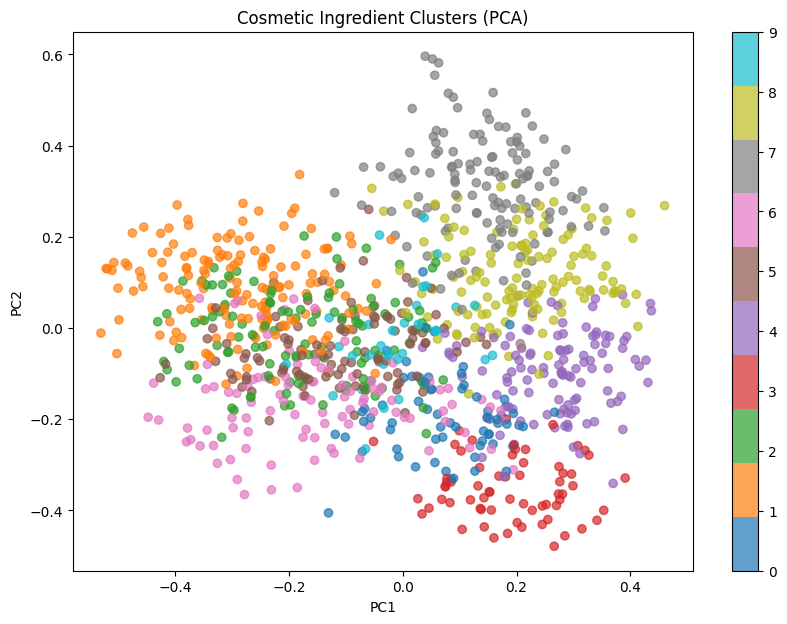

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(embeddings.cpu().numpy())

plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_vecs[:,0], pca_vecs[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.title("Cosmetic Ingredient Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter)
plt.show()